In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleandatackd/cleandata.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings # supress warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support

In [3]:
data=pd.read_csv('/kaggle/input/cleandatackd/cleandata.csv')
data=data.drop(['Unnamed: 0'],axis=1)
data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,47.0,6700.0,4.900000,0,0,0,0,0,0,1
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,54.0,7800.0,6.200000,0,0,0,0,0,0,1
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,49.0,6600.0,5.400000,0,0,0,0,0,0,1
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,51.0,7200.0,5.900000,0,0,0,0,0,0,1


# Hello, this is a notebook dedicated to making a classification model to deploy:

I already did a notebook following a couple of articles, that work is mandatory.

However, this notebook is purely my work, trying to create the best models possible following the remarks posted here https://www.kaggle.com/code/aziztaktak/academic-project-kidney-chronic-disease-articles

# NO PREPROCESSING HERE:

Well a couple of steps of preprocessing, but this dataset has already delt with NaN values as well as encoding.
Going to continue from there.

In [4]:
X = data.iloc[:,:-1].values
Y = data.iloc[:,-1].values
print(X.shape, Y.shape)

(400, 24) (400,)


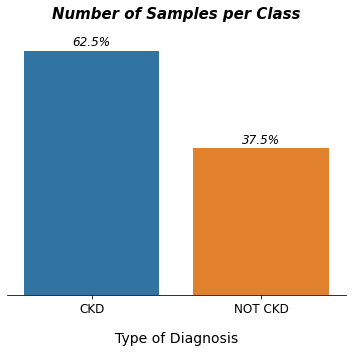

In [5]:
plt.figure(figsize=(5, 5))

sns.countplot(data = data , x = 'classification' , order = data['classification'].value_counts().index)
sns.despine(top=True, right=True, left=True, bottom=False)

plt.xticks(ticks= [0,1], labels=['CKD', 'NOT CKD'], fontsize=12)
plt.yticks([])
plt.title('Number of Samples per Class' , fontsize=15 , pad=20 , fontstyle='italic' , fontweight = 800)
plt.xlabel('Type of Diagnosis' , fontsize=14 , fontweight=400, labelpad=16)
plt.ylabel('')
ax = plt.gca()

for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/data.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())), ha='center', 
                va='bottom', color='black', xytext=(0,2), rotation='horizontal', textcoords='offset points', fontsize = 12, fontstyle = 'italic')

# plt.savefig("samples.png")
plt.tight_layout()

In the other article I used the Robustscaler, which is overall a good scaling method, **However**, it uses the IQR method which in this case not great for some values. So I will be resorting to the minmax scaler instead.

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
new_features = scaler.fit_transform(X)
print(new_features)

[[0.52272727 0.23076923 0.75       ... 0.         0.         0.        ]
 [0.05681818 0.         0.75       ... 0.         0.         0.        ]
 [0.68181818 0.23076923 0.25       ... 1.         0.         1.        ]
 ...
 [0.11363636 0.23076923 0.75       ... 0.         0.         0.        ]
 [0.17045455 0.07692308 1.         ... 0.         0.         0.        ]
 [0.63636364 0.23076923 1.         ... 0.         0.         0.        ]]


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(new_features, Y, test_size = 0.25, random_state = 0, stratify=Y)
classes = ['CKD', 'NCKD']

# Modeling without SMOTE:

So one of the things i noticed is the imbalanced data, which i'm going to deal with later on, but first I wanna see the model's performance without it & compare it after oversampling, more details below.

**KNN**

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        63
           1       0.93      1.00      0.96        37

    accuracy                           0.97       100
   macro avg       0.96      0.98      0.97       100
weighted avg       0.97      0.97      0.97       100

----------------- Overall Results -----------------
Accuracy Result: 97.00%
Precision Result: 96.25%
Recall Result: 97.62%
F1-Score Result: 96.83%


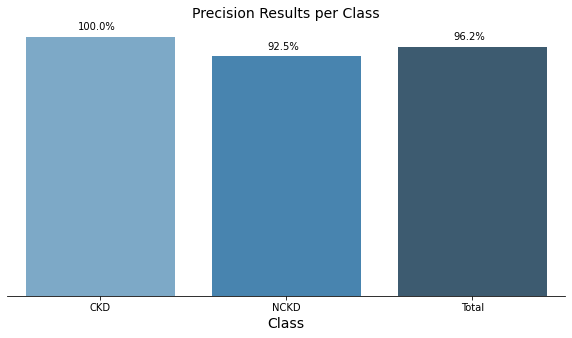

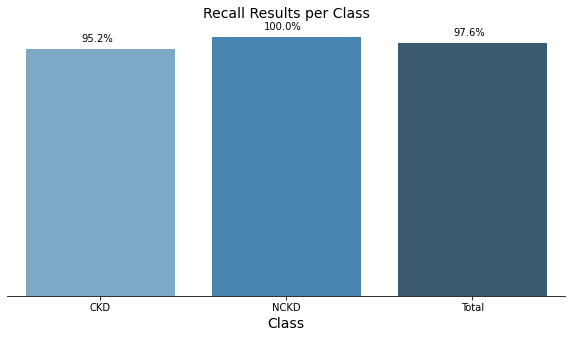

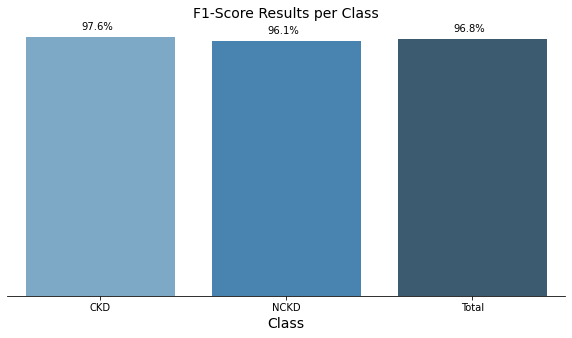

In [8]:
# model fit
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

**SVC**

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.97      1.00      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

----------------- Overall Results -----------------
Accuracy Result: 99.00%
Precision Result: 98.68%
Recall Result: 99.21%
F1-Score Result: 98.93%


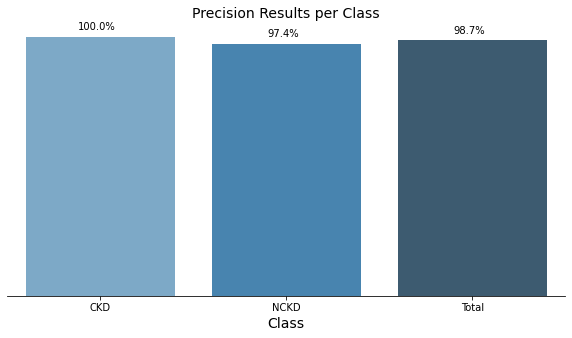

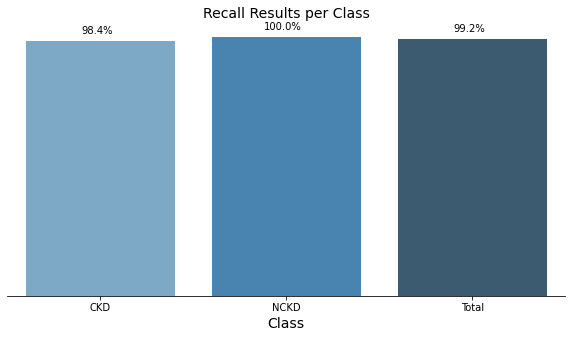

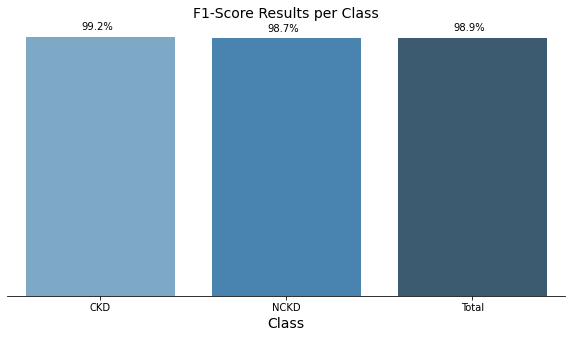

In [9]:
# model fit
knn = SVC(gamma=0.1, C=1000)
knn.fit(x_train, y_train)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

**NaiveBayes**

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        63
           1       0.88      1.00      0.94        37

    accuracy                           0.95       100
   macro avg       0.94      0.96      0.95       100
weighted avg       0.96      0.95      0.95       100

----------------- Overall Results -----------------
Accuracy Result: 95.00%
Precision Result: 94.05%
Recall Result: 96.03%
F1-Score Result: 94.77%


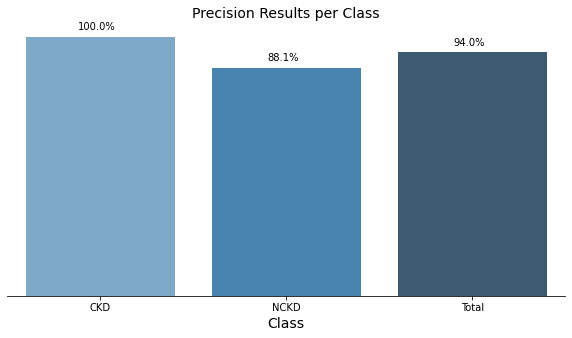

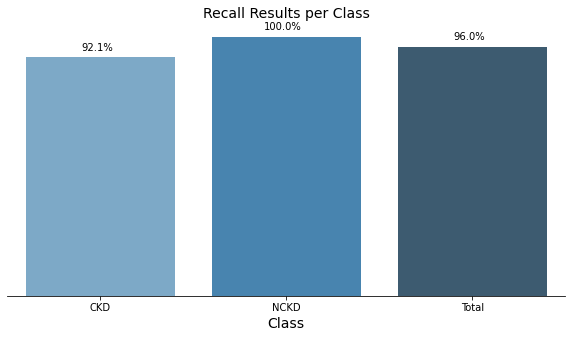

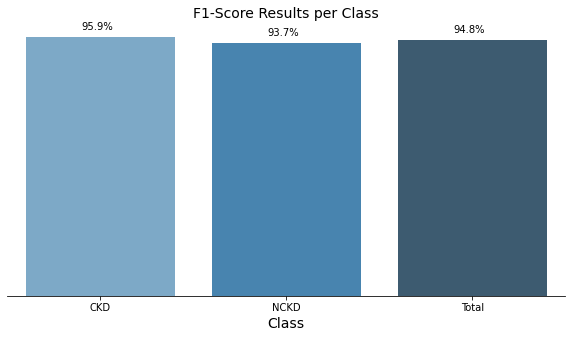

In [10]:
# model fit
knn = GaussianNB()
knn.fit(x_train, y_train)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

**DecisionTreeClassifier()**

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.95      0.95      0.95        37

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

----------------- Overall Results -----------------
Accuracy Result: 96.00%
Precision Result: 95.71%
Recall Result: 95.71%
F1-Score Result: 95.71%


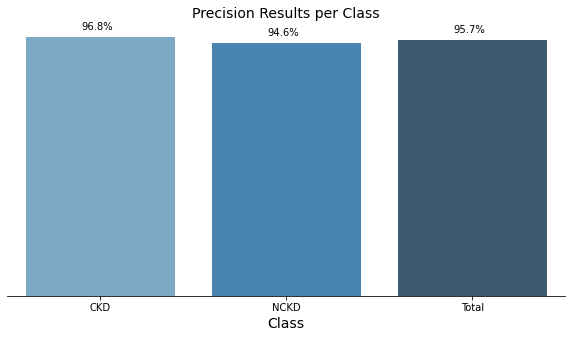

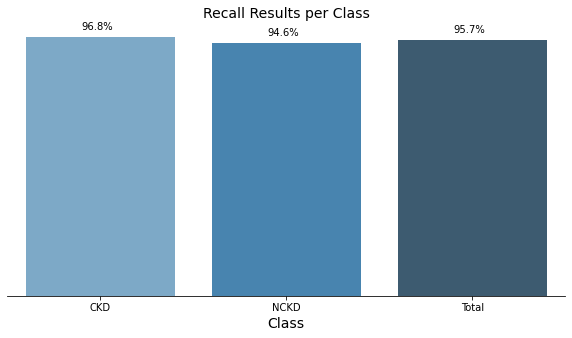

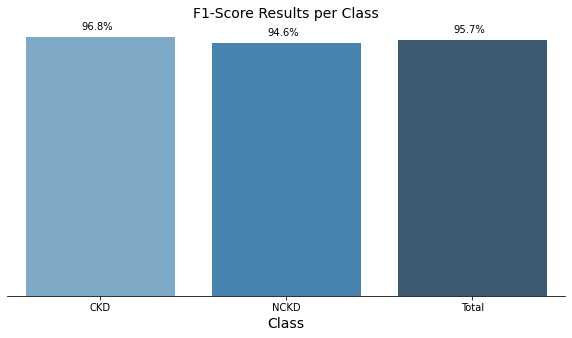

In [11]:
# model fit
knn = DecisionTreeClassifier()
knn.fit(x_train, y_train)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

**RandomForestClassifier**

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        63
           1       1.00      0.97      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

----------------- Overall Results -----------------
Accuracy Result: 99.00%
Precision Result: 99.22%
Recall Result: 98.65%
F1-Score Result: 98.92%


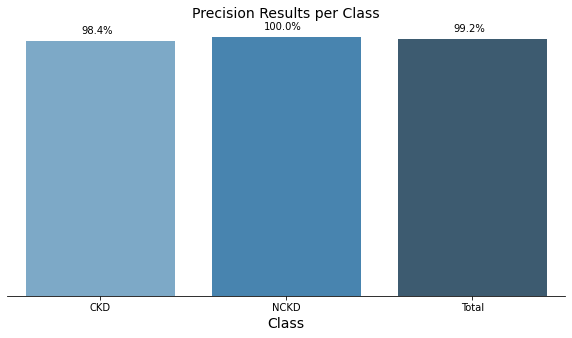

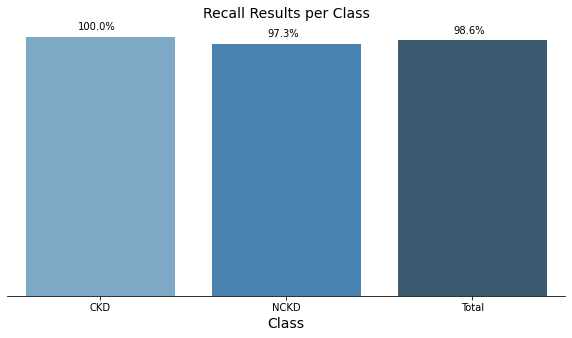

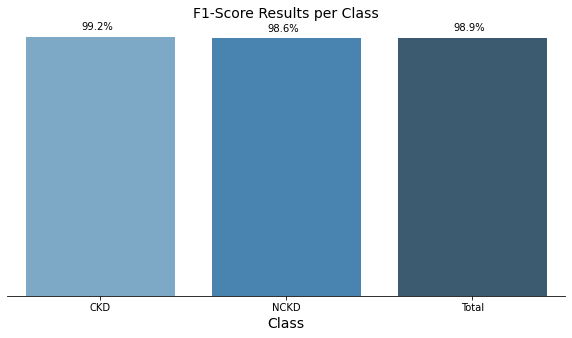

In [12]:
# model fit
knn = RandomForestClassifier()
knn.fit(x_train, y_train)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

**AdaBoostClassifier**

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       0.95      0.97      0.96        37

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

----------------- Overall Results -----------------
Accuracy Result: 97.00%
Precision Result: 96.56%
Recall Result: 97.06%
F1-Score Result: 96.80%


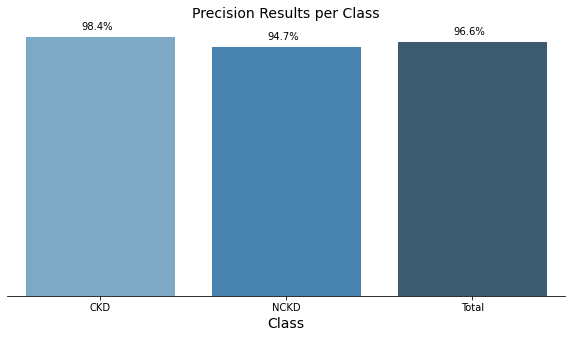

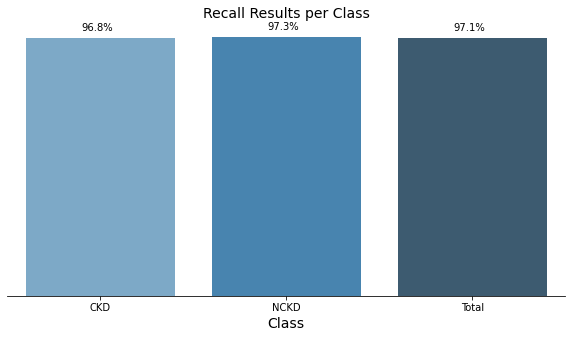

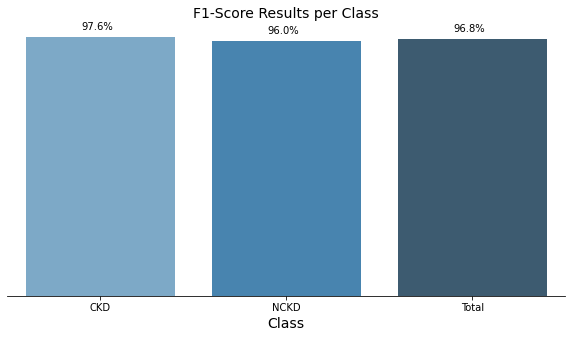

In [13]:
# model fit
knn = AdaBoostClassifier()
knn.fit(x_train, y_train)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

# Kfold CrossValidation V1.0 (No Smote):


In [14]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 0
classifiers = []


classifiers.append(KNeighborsClassifier())
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier()))
classifiers.append(RandomForestClassifier())


In [15]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res_1 = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","SVC","DecisionTree","GNB","AdaBoost",
"RandomForest"]})

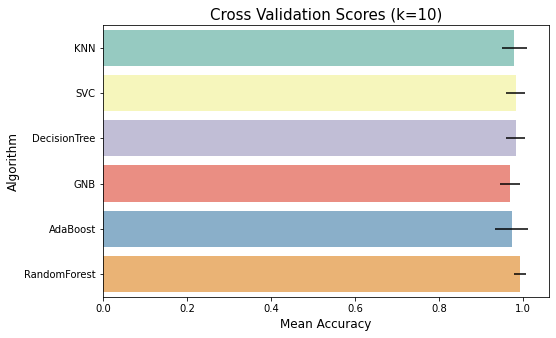

In [16]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res_1, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean Accuracy", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [17]:
cv_res_1

,CrossValMeans,CrossValerrors,Algorithm
0,0.980000,0.030551,KNN
1,0.983333,0.022361,SVC
2,0.983333,0.022361,DecisionTree
3,0.970000,0.023333,GNB
4,0.973333,0.038873,AdaBoost
5,0.993333,0.013333,RandomForest


All models tested performed well, even without oversampling, Notably the RandomForest outperformed everyone.

Let's see if that's the case with the f1_score

In [18]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","SVC","DecisionTree","GNB","AdaBoost",
"RandomForest"]})

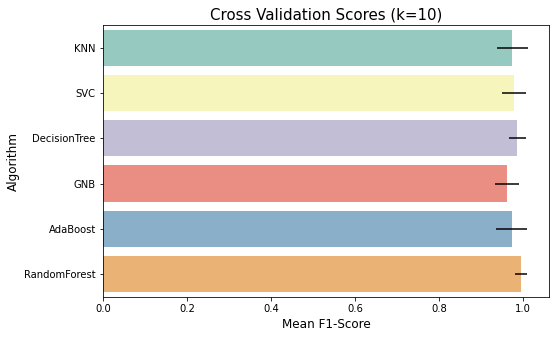

In [19]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean F1-Score", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [20]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.975304,0.036989,KNN
1,0.978971,0.028112,SVC
2,0.986542,0.020585,DecisionTree
3,0.961942,0.029268,GNB
4,0.973123,0.036174,AdaBoost
5,0.995238,0.014286,RandomForest


As expected, the RandomForest's performance is still the highest here.

# Using Smote!

In [21]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 113
Before OverSampling, counts of label '0': 187 



In [22]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_res, y_train_res = oversample.fit_resample(x_train, y_train)

In [23]:
print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (374, 24)
After OverSampling, the shape of train_y: (374,) 

After OverSampling, counts of label '1': 187
After OverSampling, counts of label '0': 187


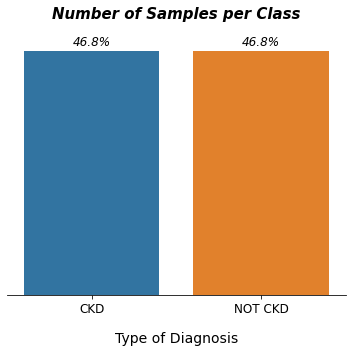

In [24]:
plt.figure(figsize=(5, 5))

sns.countplot(x = y_train_res)
sns.despine(top=True, right=True, left=True, bottom=False)

plt.xticks(ticks= [0,1], labels=['CKD', 'NOT CKD'], fontsize=12)
plt.yticks([])
plt.title('Number of Samples per Class' , fontsize=15 , pad=20 , fontstyle='italic' , fontweight = 800)
plt.xlabel('Type of Diagnosis' , fontsize=14 , fontweight=400, labelpad=16)
plt.ylabel('')
ax = plt.gca()

for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/data.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())), ha='center', 
                va='bottom', color='black', xytext=(0,2), rotation='horizontal', textcoords='offset points', fontsize = 12, fontstyle = 'italic')

# plt.savefig("samples.png")
plt.tight_layout()

Okay let's go and refit the models, see if this upgraded the model's performance.

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.90      1.00      0.95        37

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100

----------------- Overall Results -----------------
Accuracy Result: 96.00%
Precision Result: 95.12%
Recall Result: 96.83%
F1-Score Result: 95.80%


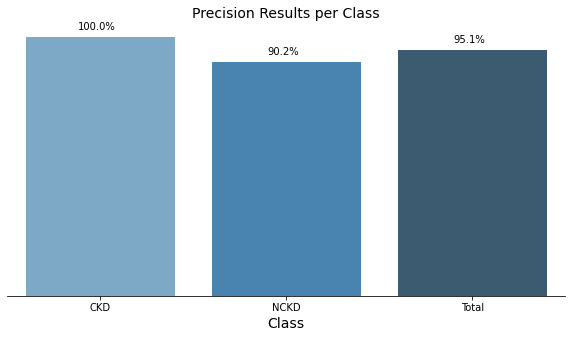

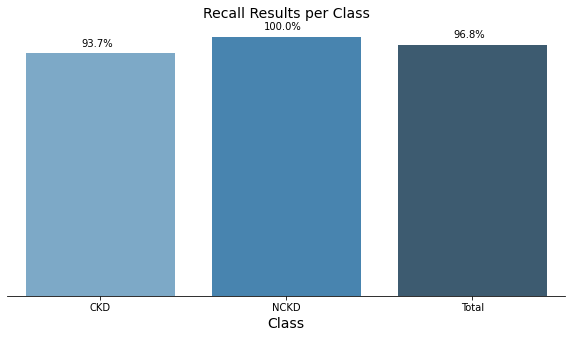

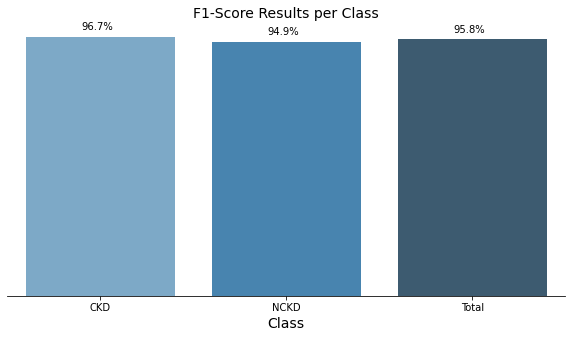

In [25]:
# model fit
knn = KNeighborsClassifier()
knn.fit(x_train_res, y_train_res)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.97      1.00      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

----------------- Overall Results -----------------
Accuracy Result: 99.00%
Precision Result: 98.68%
Recall Result: 99.21%
F1-Score Result: 98.93%


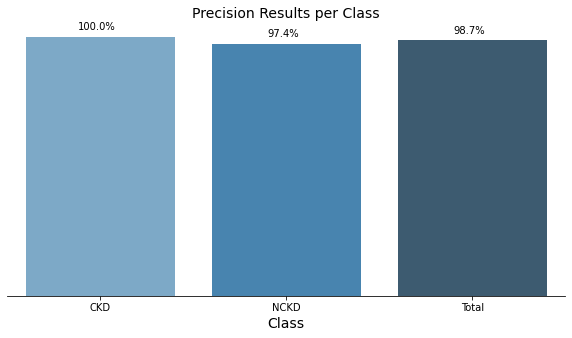

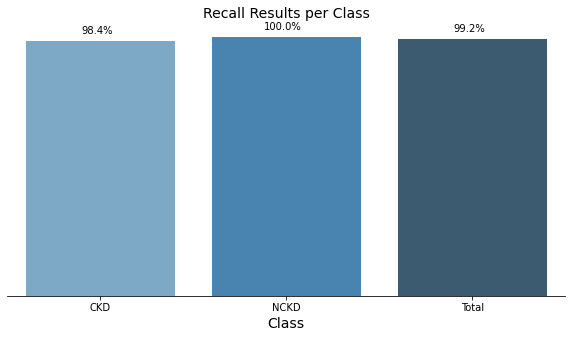

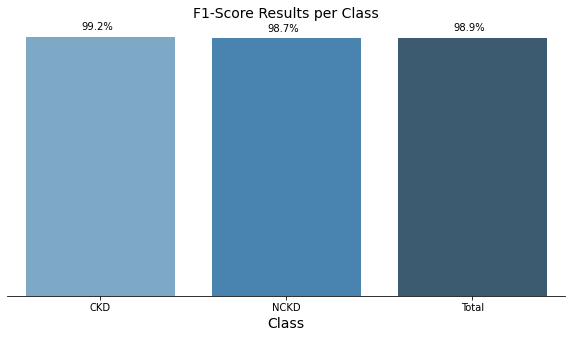

In [26]:
# model fit
knn = SVC(gamma=0.1, C=1000)
knn.fit(x_train_res, y_train_res)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        63
           1       0.86      1.00      0.92        37

    accuracy                           0.94       100
   macro avg       0.93      0.95      0.94       100
weighted avg       0.95      0.94      0.94       100

----------------- Overall Results -----------------
Accuracy Result: 94.00%
Precision Result: 93.02%
Recall Result: 95.24%
F1-Score Result: 93.75%


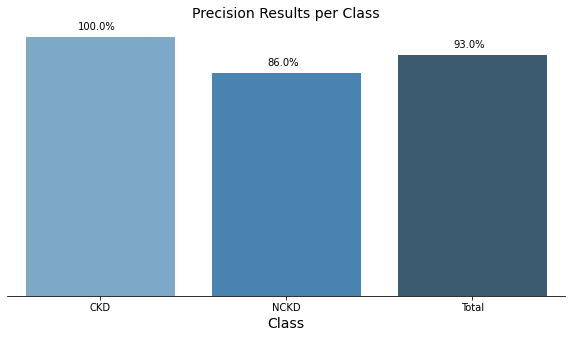

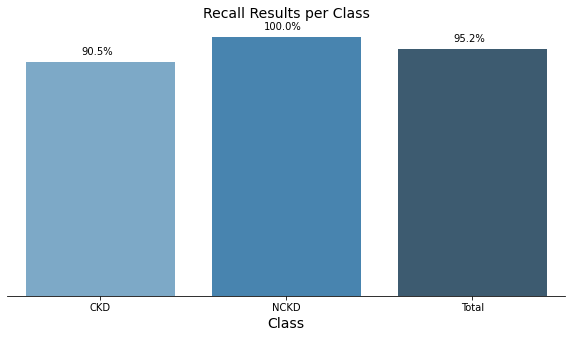

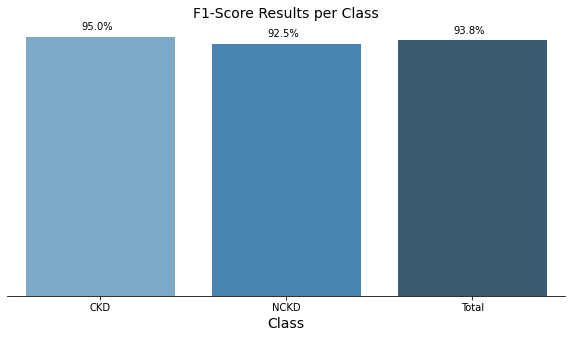

In [27]:
# model fit
knn = GaussianNB(var_smoothing=0.02)
knn.fit(x_train_res, y_train_res)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.97      0.95      0.96        37

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

----------------- Overall Results -----------------
Accuracy Result: 97.00%
Precision Result: 97.05%
Recall Result: 96.50%
F1-Score Result: 96.76%


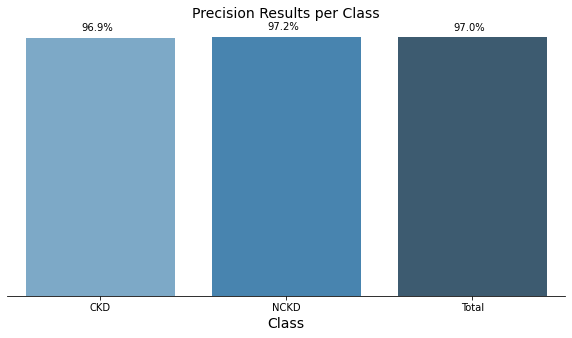

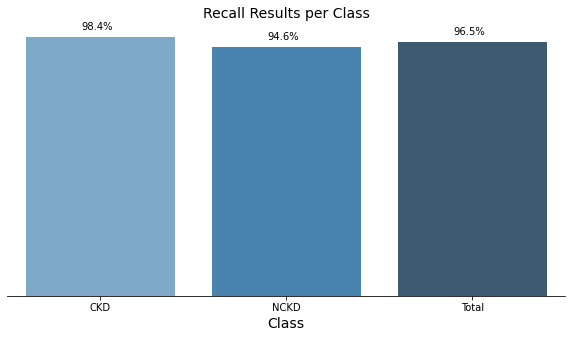

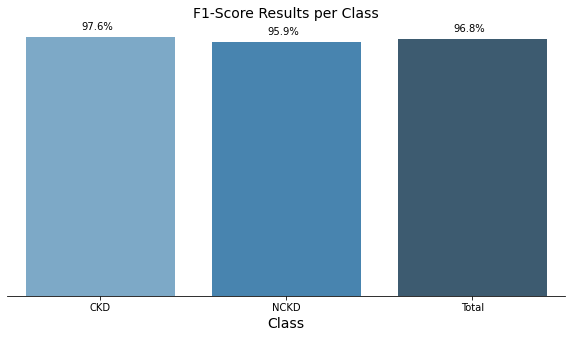

In [28]:
# model fit
knn = DecisionTreeClassifier(criterion='entropy')
knn.fit(x_train_res, y_train_res)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        63
           1       1.00      0.97      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

----------------- Overall Results -----------------
Accuracy Result: 99.00%
Precision Result: 99.22%
Recall Result: 98.65%
F1-Score Result: 98.92%


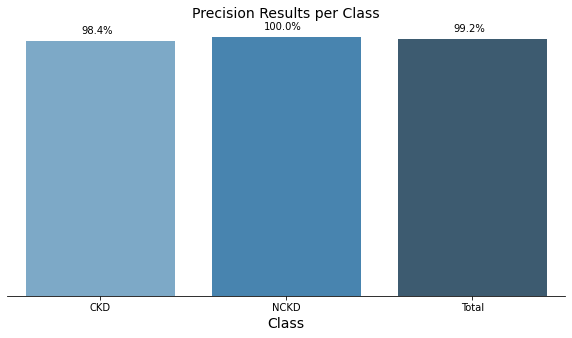

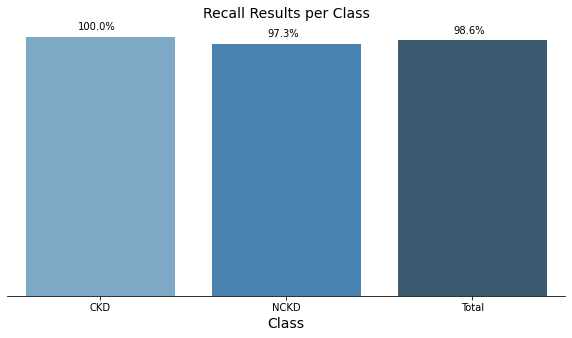

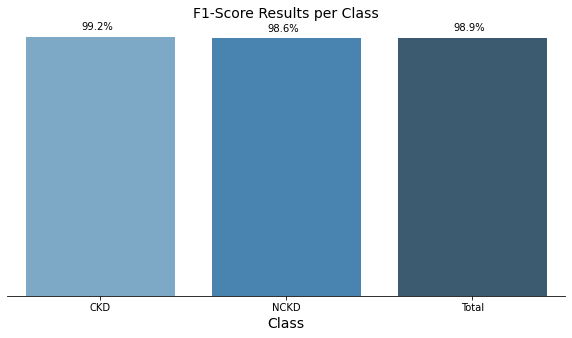

In [29]:
# model fit
knn = RandomForestClassifier()
knn.fit(x_train_res, y_train_res)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       0.95      0.97      0.96        37

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

----------------- Overall Results -----------------
Accuracy Result: 97.00%
Precision Result: 96.56%
Recall Result: 97.06%
F1-Score Result: 96.80%


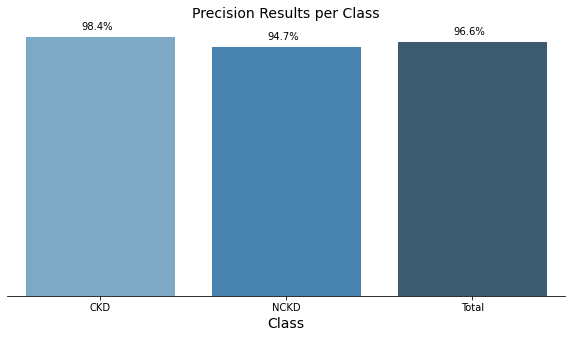

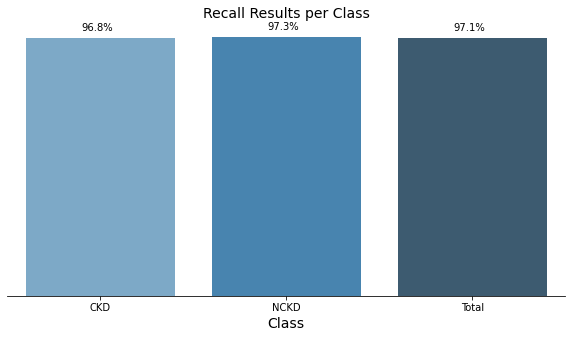

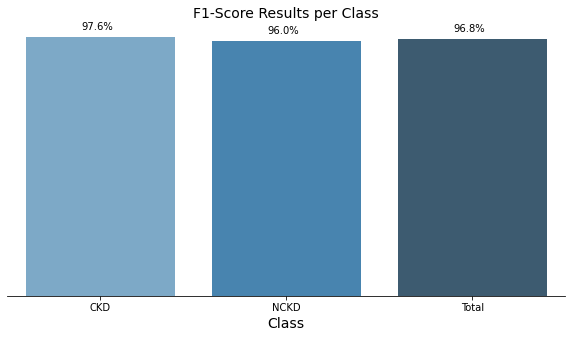

In [30]:
# model fit
knn = AdaBoostClassifier()
knn.fit(x_train_res, y_train_res)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

In [31]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train_res, y = y_train_res, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","SVC","DecisionTree","GNB","AdaBoost",
"RandomForest"]})

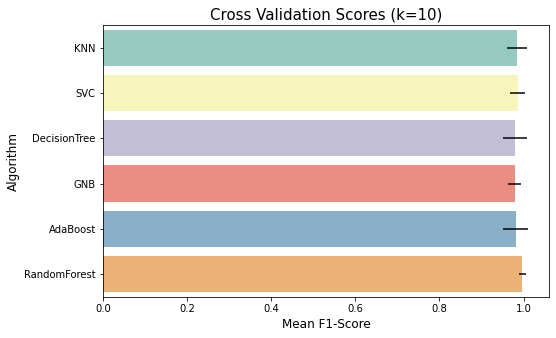

In [32]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean F1-Score", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [33]:
cv_res #After Smote

,CrossValMeans,CrossValerrors,Algorithm
0,0.983997,0.024214,KNN
1,0.986629,0.017814,SVC
2,0.978734,0.028518,DecisionTree
3,0.978663,0.015888,GNB
4,0.981437,0.029118,AdaBoost
5,0.997297,0.008108,RandomForest


In [34]:
cv_res_1 #Before Smote

,CrossValMeans,CrossValerrors,Algorithm
0,0.980000,0.030551,KNN
1,0.983333,0.022361,SVC
2,0.983333,0.022361,DecisionTree
3,0.970000,0.023333,GNB
4,0.973333,0.038873,AdaBoost
5,0.993333,0.013333,RandomForest


# Evaluation:
Okay this is interesting, Every model has had a small improvement in accuracy, except for RandomForest. True the variation isn't high but it's still something.

In [35]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train_res, y = y_train_res, scoring = "f1", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","SVC","DecisionTree","GNB","AdaBoost",
"RandomForest"]})

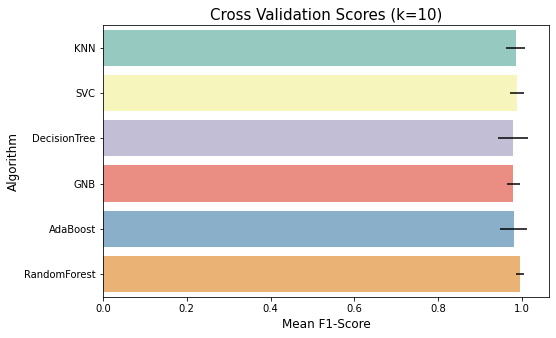

In [36]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean F1-Score", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [37]:
cv_res #F1_score after Smote

,CrossValMeans,CrossValerrors,Algorithm
0,0.984713,0.022662,KNN
1,0.987030,0.017136,SVC
2,0.978655,0.035186,DecisionTree
3,0.979200,0.015288,GNB
4,0.979657,0.032846,AdaBoost
5,0.994733,0.010538,RandomForest


RandomForest is still outperforming every other model, let's take a look at its classification report.

In [38]:
# model fit
knn = RandomForestClassifier()
knn.fit(x_train_res, y_train_res)

# prediction
preds = knn.predict(x_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        63
           1       1.00      0.97      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



# Using Stacking Classifier:

Stacking Classifier uses estimators, as in models, and stacks each and every output and uses a final estimator to compute the results! 
Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

In [39]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
svm = SVC(gamma=1, C=1000)
adab = AdaBoostClassifier()
rf = RandomForestClassifier()

In [40]:
stackf = StackingClassifier(estimators = [('svm', svm), ('rf', rf), ('adab', adab)], final_estimator=SVC(), n_jobs=-1,
                           passthrough=True)
stackf.fit(x_train_res, y_train_res)

StackingClassifier(estimators=[('svm', SVC(C=1000, gamma=1)),
                               ('rf', RandomForestClassifier()),
                               ('adab', AdaBoostClassifier())],
                   final_estimator=SVC(), n_jobs=-1, passthrough=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        37

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

----------------- Overall Results -----------------
Accuracy Result: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%


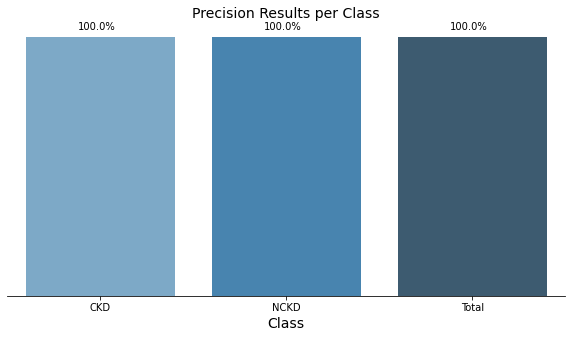

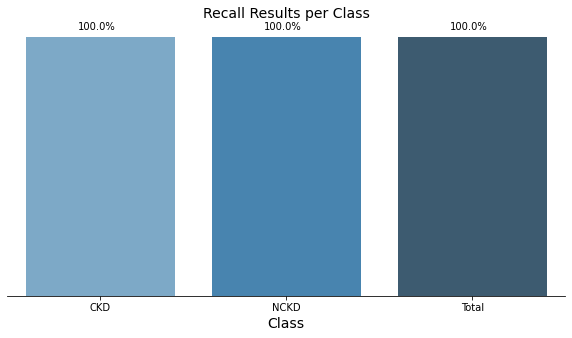

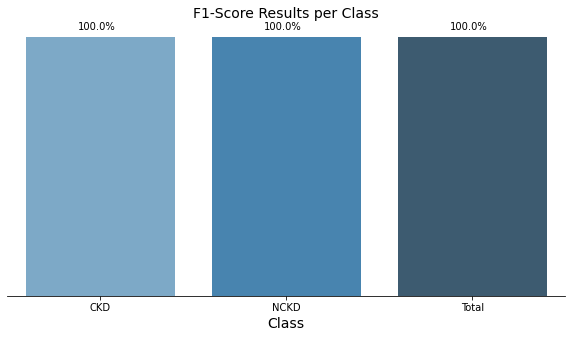

In [41]:
preds = stackf.predict(x_test)
print(classification_report(y_test, preds))

acc = accuracy_score(y_test, preds)
results_all = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_test, preds, average=None, zero_division=1)
metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    # Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14)
    ax.set_ylabel(metric,fontsize = 14)
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 14);

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))        # Recall of the whole Dataset
print('F1-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))      # F1-Score of the whole Dataset

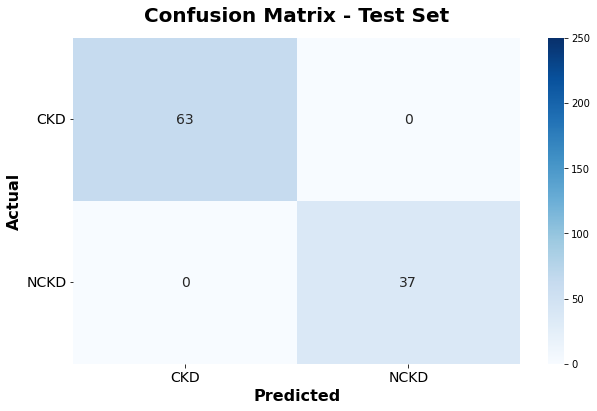

In [42]:
from sklearn.metrics import confusion_matrix

CMatrix = pd.DataFrame(confusion_matrix(y_test, preds), columns = classes, index = classes)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues', annot_kws={"size": 14})
ax.set_xlabel('Predicted',fontsize = 16,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 0, fontsize=14);
ax.set_ylabel('Actual',fontsize = 16,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0, fontsize=14);
ax.set_title('Confusion Matrix - Test Set', fontsize = 20, weight = 'bold', pad=16);
plt.savefig("confusion_matrix.png")

# This is interesting and borderline scary to be honest

I've checked out so many notebooks and it's quite simple to get 100% on a lot of models. I don't know if the dataset was made to be this accurate or if it's a case of overfitting